<a href="https://colab.research.google.com/github/Guilli12pm/ML_proj/blob/master/project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning project: Facial Recognition 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

'1.13.1'

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

##Download the images

In [3]:
#https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz
import pathlib
data_root_orig = tf.keras.utils.get_file('next_ite',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

14098432/14098079 [==============================] - 0s 0us/step
/root/.keras/datasets/next_ite


##Inspect the dataset

In [4]:
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/next_ite/.DS_Store
/root/.keras/datasets/next_ite/Nicholas_S
/root/.keras/datasets/next_ite/Miha_S
/root/.keras/datasets/next_ite/Guillaume_Loranchet
/root/.keras/datasets/next_ite/Guillaume_Paya


We create a list of all pictures and shuffle

In [0]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)

In [6]:
all_image_paths[:5]

['/root/.keras/datasets/next_ite/Guillaume_Paya/Guillaume_Paya_43.png',
 '/root/.keras/datasets/next_ite/Guillaume_Paya/Guillaume_Paya_11.png',
 '/root/.keras/datasets/next_ite/Guillaume_Paya/Guillaume_Paya_93.png',
 '/root/.keras/datasets/next_ite/Miha_S/Miha_S_70.png',
 '/root/.keras/datasets/next_ite/Guillaume_Paya/Guillaume_Paya_2.png']

###Show images

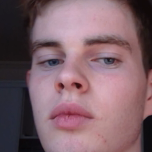

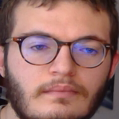

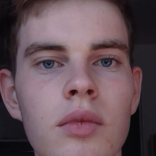

In [7]:
import IPython.display as display

for n in range(3):
  image_path = random.choice(all_image_paths)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

###Label images

In [8]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']

In [9]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Guillaume_Loranchet': 0, 'Guillaume_Paya': 1, 'Miha_S': 2, 'Nicholas_S': 3}

In [10]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 1, 1, 2, 1, 0, 2, 1, 3, 3]


###Load images with Tensor Flow

In [11]:
img_path = all_image_paths[0]
img_path

'/root/.keras/datasets/next_ite/Guillaume_Paya/Guillaume_Paya_43.png'

In [0]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

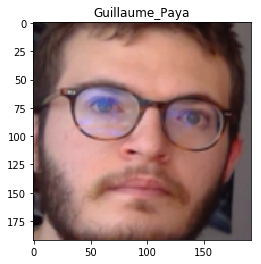

In [14]:
import matplotlib.pyplot as plt

image_path = all_image_paths[1]
label = all_image_labels[1]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
#plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

In [15]:
import numpy as np

x_train_aux = [load_and_preprocess_image(all_image_paths[i]) for i in range(len(all_image_paths))]
x_train = np.array([np.array(x_train_aux[i]) for i in range(len(x_train_aux))])
print(x_train.shape)

y_train = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels])
print(y_train.shape)

labels = label_names
print(labels)

(396, 192, 192, 3)
(396, 4)
['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']


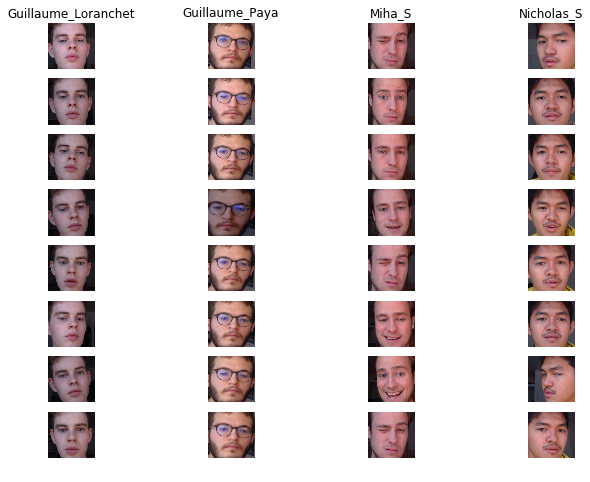

In [16]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, len(categories[0]), figsize=(11,8))
    
    for i in range(len(categories[0])):
        count = 0
        j = 0
        while count < n and j < 50000:
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels)

##Build a tf.data.Dataset

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [0]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [0]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


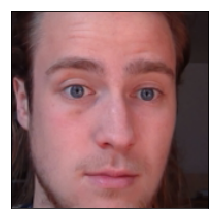

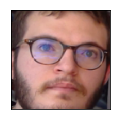

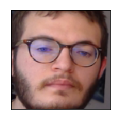

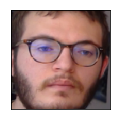

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  #plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

In [0]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [0]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

Miha_S
Guillaume_Paya
Guillaume_Paya
Guillaume_Paya
Guillaume_Paya
Guillaume_Paya
Miha_S
Nicholas_S
Miha_S
Guillaume_Paya


In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [0]:
print(image_label_ds)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [0]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [0]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [0]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [0]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 1s 0us/step


In [0]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [0]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [0]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [0]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [0]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -1.5796653
max logit: 1.8470368

Shape: (32, 4)


In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [0]:
len(model.trainable_variables)

2

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

13.0

In [0]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 12s 4s/step - loss: 5.5652 - acc: 0.1875


In [0]:
import time

def timeit(ds, batches=2*steps_per_epoch+1):
  overall_start = time.time()
  # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
  # before starting the timer
  it = iter(ds.take(batches+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(batches, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(end-overall_start))

In [0]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [0]:
timeit(ds)

...
27.0 batches: 1.8377976417541504 s
470.12793 Images/s
Total time: 2.5691800117492676s


In [0]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [0]:
timeit(ds)

...
27.0 batches: 1.616187572479248 s
534.59141 Images/s
Total time: 2.3432955741882324s


In [0]:
ds = image_label_ds.cache()
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [0]:
timeit(ds)

...
27.0 batches: 0.18660402297973633 s
4630.12526 Images/s
Total time: 0.8874011039733887s


In [0]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

In [0]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

In [0]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [0]:
timeit(ds)

...
27.0 batches: 1.4800910949707031 s
583.74785 Images/s
Total time: 2.1226065158843994s


In [0]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

In [0]:
ds = image_ds.map(tf.serialize_tensor)
ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [0]:
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

In [0]:
ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
  result = tf.parse_tensor(x, out_type=tf.float32)
  result = tf.reshape(result, [192, 192, 3])
  return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

In [0]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>